In [9]:
import pandas as pd 
import numpy as np 
import implicit
from scipy.sparse import csr_matrix


In [13]:
hot_encoded = pd.read_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/balanced_ground_truth_hot_vector.csv")
sparse_matrix = csr_matrix(hot_encoded.iloc[:,1:].values)

In [59]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=10, iterations=100, calculate_training_loss = True)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(sparse_matrix)

In [92]:
np.sum(np.abs(np.matmul(model.item_factors,model.user_factors.T) - hot_encoded.iloc[:,1:].values))

15685.0

In [90]:
track_embeddings = pd.DataFrame(model.item_factors)
track_embeddings["song_id"] = hot_encoded.song_id
cols = track_embeddings.columns.tolist()
cols = cols[-1:] + cols[:-1]
track_embeddings = track_embeddings[cols]
track_embeddings.to_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/tracks_embeddings_groundtruth.csv",index = False)

In [97]:
# Getting training validation and test splits
trainings = pd.read_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/train_ground_truth.csv")
validations = pd.read_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/validation_ground_truth.csv")
test = pd.read_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/test_ground_truth.csv")
train_embeddings = track_embeddings[track_embeddings.song_id.isin(trainings.song_id)]
valid_embeddings = track_embeddings[track_embeddings.song_id.isin(validations.song_id)]
test_embeddings = track_embeddings[track_embeddings.song_id.isin(test.song_id)]

    train_embeddings.to_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/train_embeddings_groundtruth.csv",index = False)
valid_embeddings.to_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/validation_embeddings_groundtruth.csv",index = False)
test_embeddings.to_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/test_embeddings_groundtruth.csv",index = False)

In [91]:
context_embeddings = pd.DataFrame(model.user_factors)
context_embeddings["context"] = hot_encoded.columns[1:]
cols = context_embeddings.columns.tolist()
cols = cols[-1:] + cols[:-1]
context_embeddings = context_embeddings[cols]
context_embeddings.to_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/context_embeddings.csv",index = False)

In [100]:
predicts = np.loadtxt("/home/karim/Documents/research/exeriment_results_server_backup/experiments_results/embeddings_C4/2019-09-11_15-18-58/predicted_embedings.out",delimiter=',')

In [109]:
context_embeddings = pd.read_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/context_embeddings.csv")

(10, 15)

In [111]:
test_pred_prob = np.matmul(predicts,context_embeddings.iloc[:,1:].values.T)

In [112]:
test_ground_truth = pd.read_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/test_ground_truth_binarized.csv")
all_ground_truth = pd.read_csv("/home/karim/Documents/research/sourceCode/context_classification_cnn/GroundTruth/balanced_ground_truth_hot_vector.csv")
# all_ground_truth.drop("playlists_count", axis=1, inplace=True);
all_ground_truth = all_ground_truth[all_ground_truth.song_id.isin(test_ground_truth.song_id)]
all_ground_truth = all_ground_truth.set_index('song_id')
all_ground_truth = all_ground_truth.loc[test_ground_truth.song_id]
test_classes = all_ground_truth.values
test_classes = test_classes.astype(int)

In [119]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, \
    hamming_loss
test_pred = np.round(test_pred_prob)
test_pred = np.clip(test_pred,0,1)
# Accuracy
accuracy = 100 * accuracy_score(test_classes, test_pred)
print("Exact match accuracy is: " + str(accuracy) + "%")
# Area Under the Receiver Operating Characteristic Curve (ROC AUC)
auc_roc = roc_auc_score(test_classes, test_pred_prob)
print("Macro Area Under the Curve (AUC) is: " + str(auc_roc))
auc_roc_micro = roc_auc_score(test_classes, test_pred_prob, average="micro")
print("Micro Area Under the Curve (AUC) is: " + str(auc_roc_micro))
auc_roc_weighted = roc_auc_score(test_classes, test_pred_prob, average="weighted")
print("Weighted Area Under the Curve (AUC) is: " + str(auc_roc_weighted))
# Hamming loss is the fraction of labels that are incorrectly predicted.
hamming_error = hamming_loss(test_classes, test_pred)
print("Hamming Loss (ratio of incorrect tags) is: " + str(hamming_error))

Exact match accuracy is: 1.0272002629632673%
Macro Area Under the Curve (AUC) is: 0.49312333910129164
Micro Area Under the Curve (AUC) is: 0.5609188483524127
Weighted Area Under the Curve (AUC) is: 0.49206232140350387
Hamming Loss (ratio of incorrect tags) is: 0.475503328128852


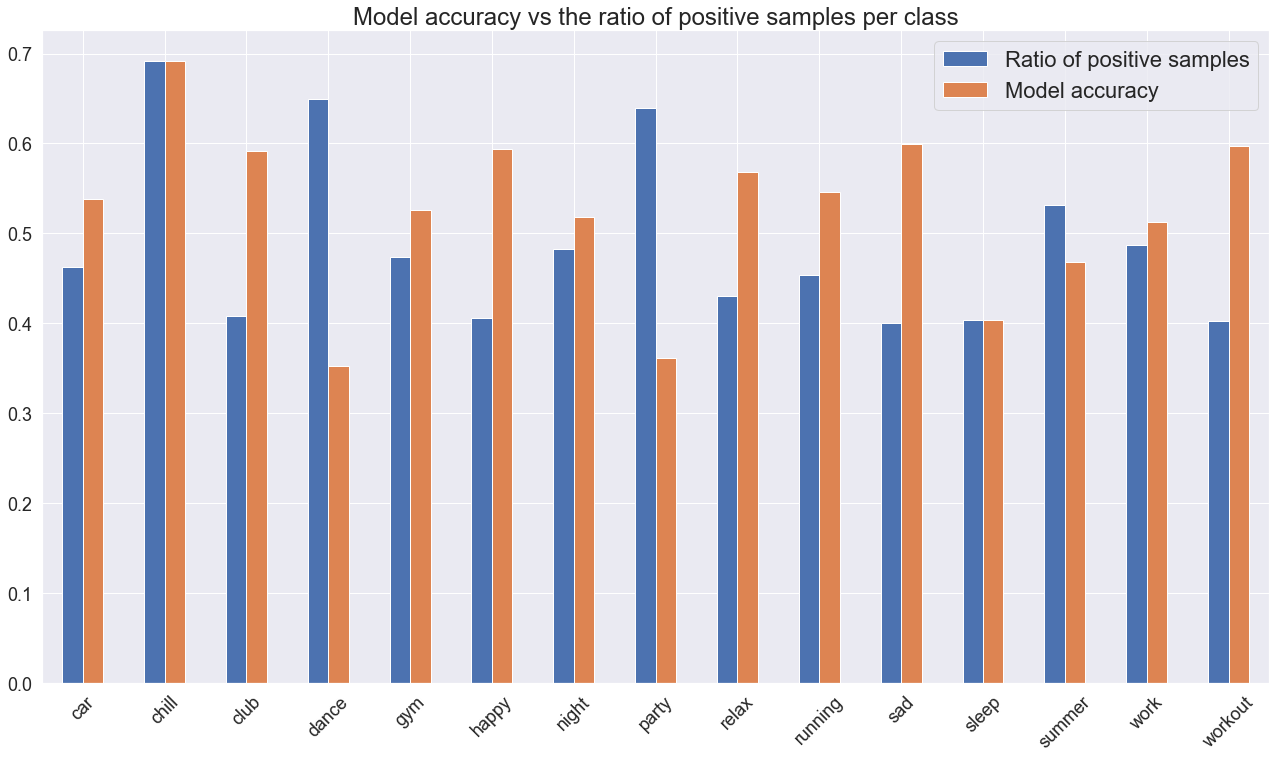

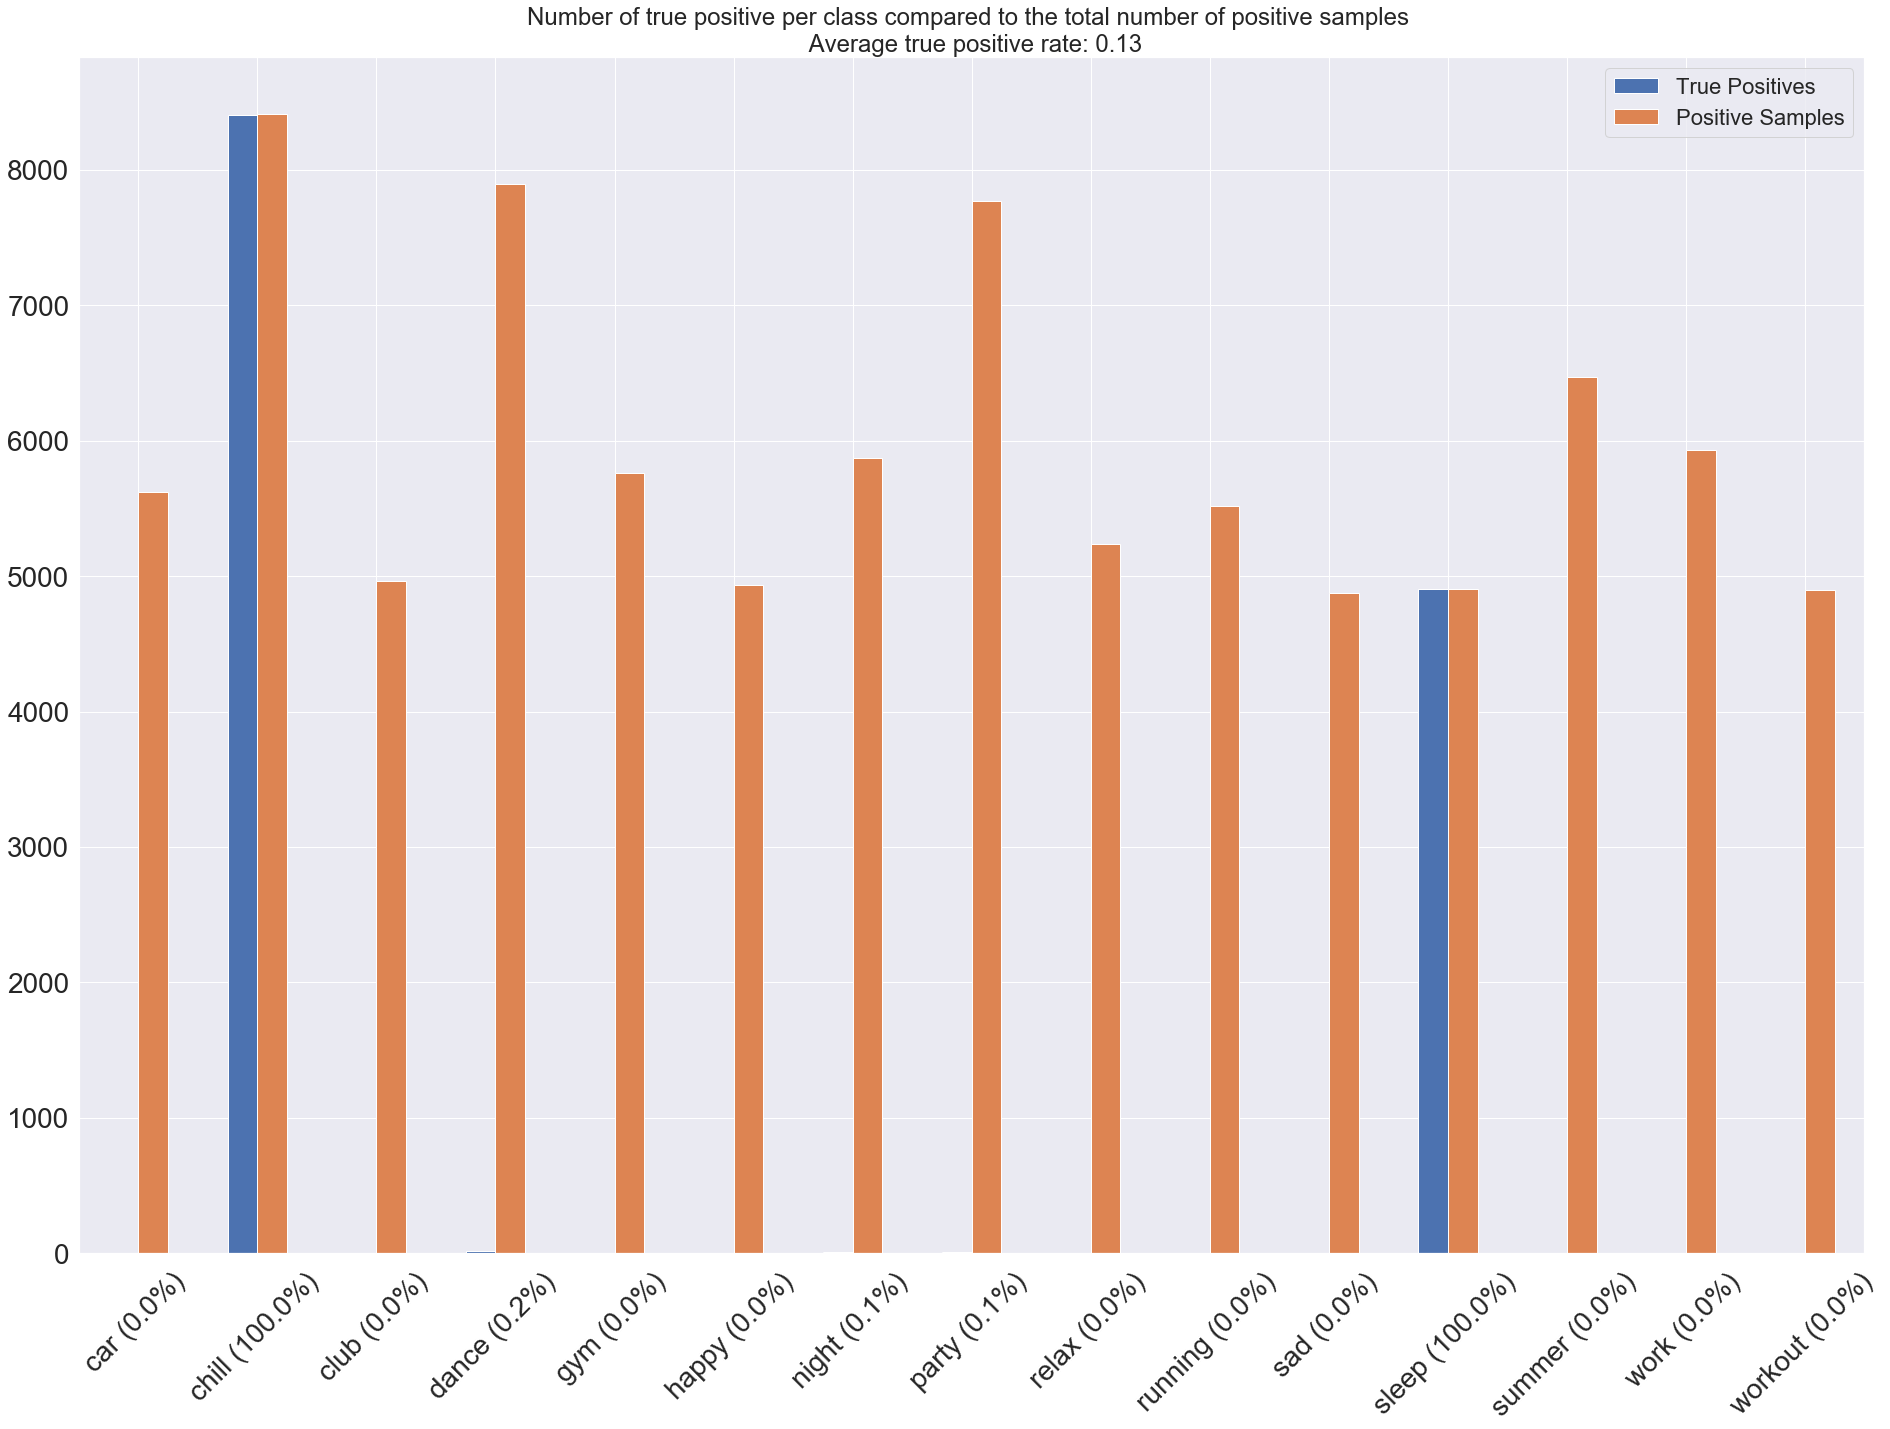

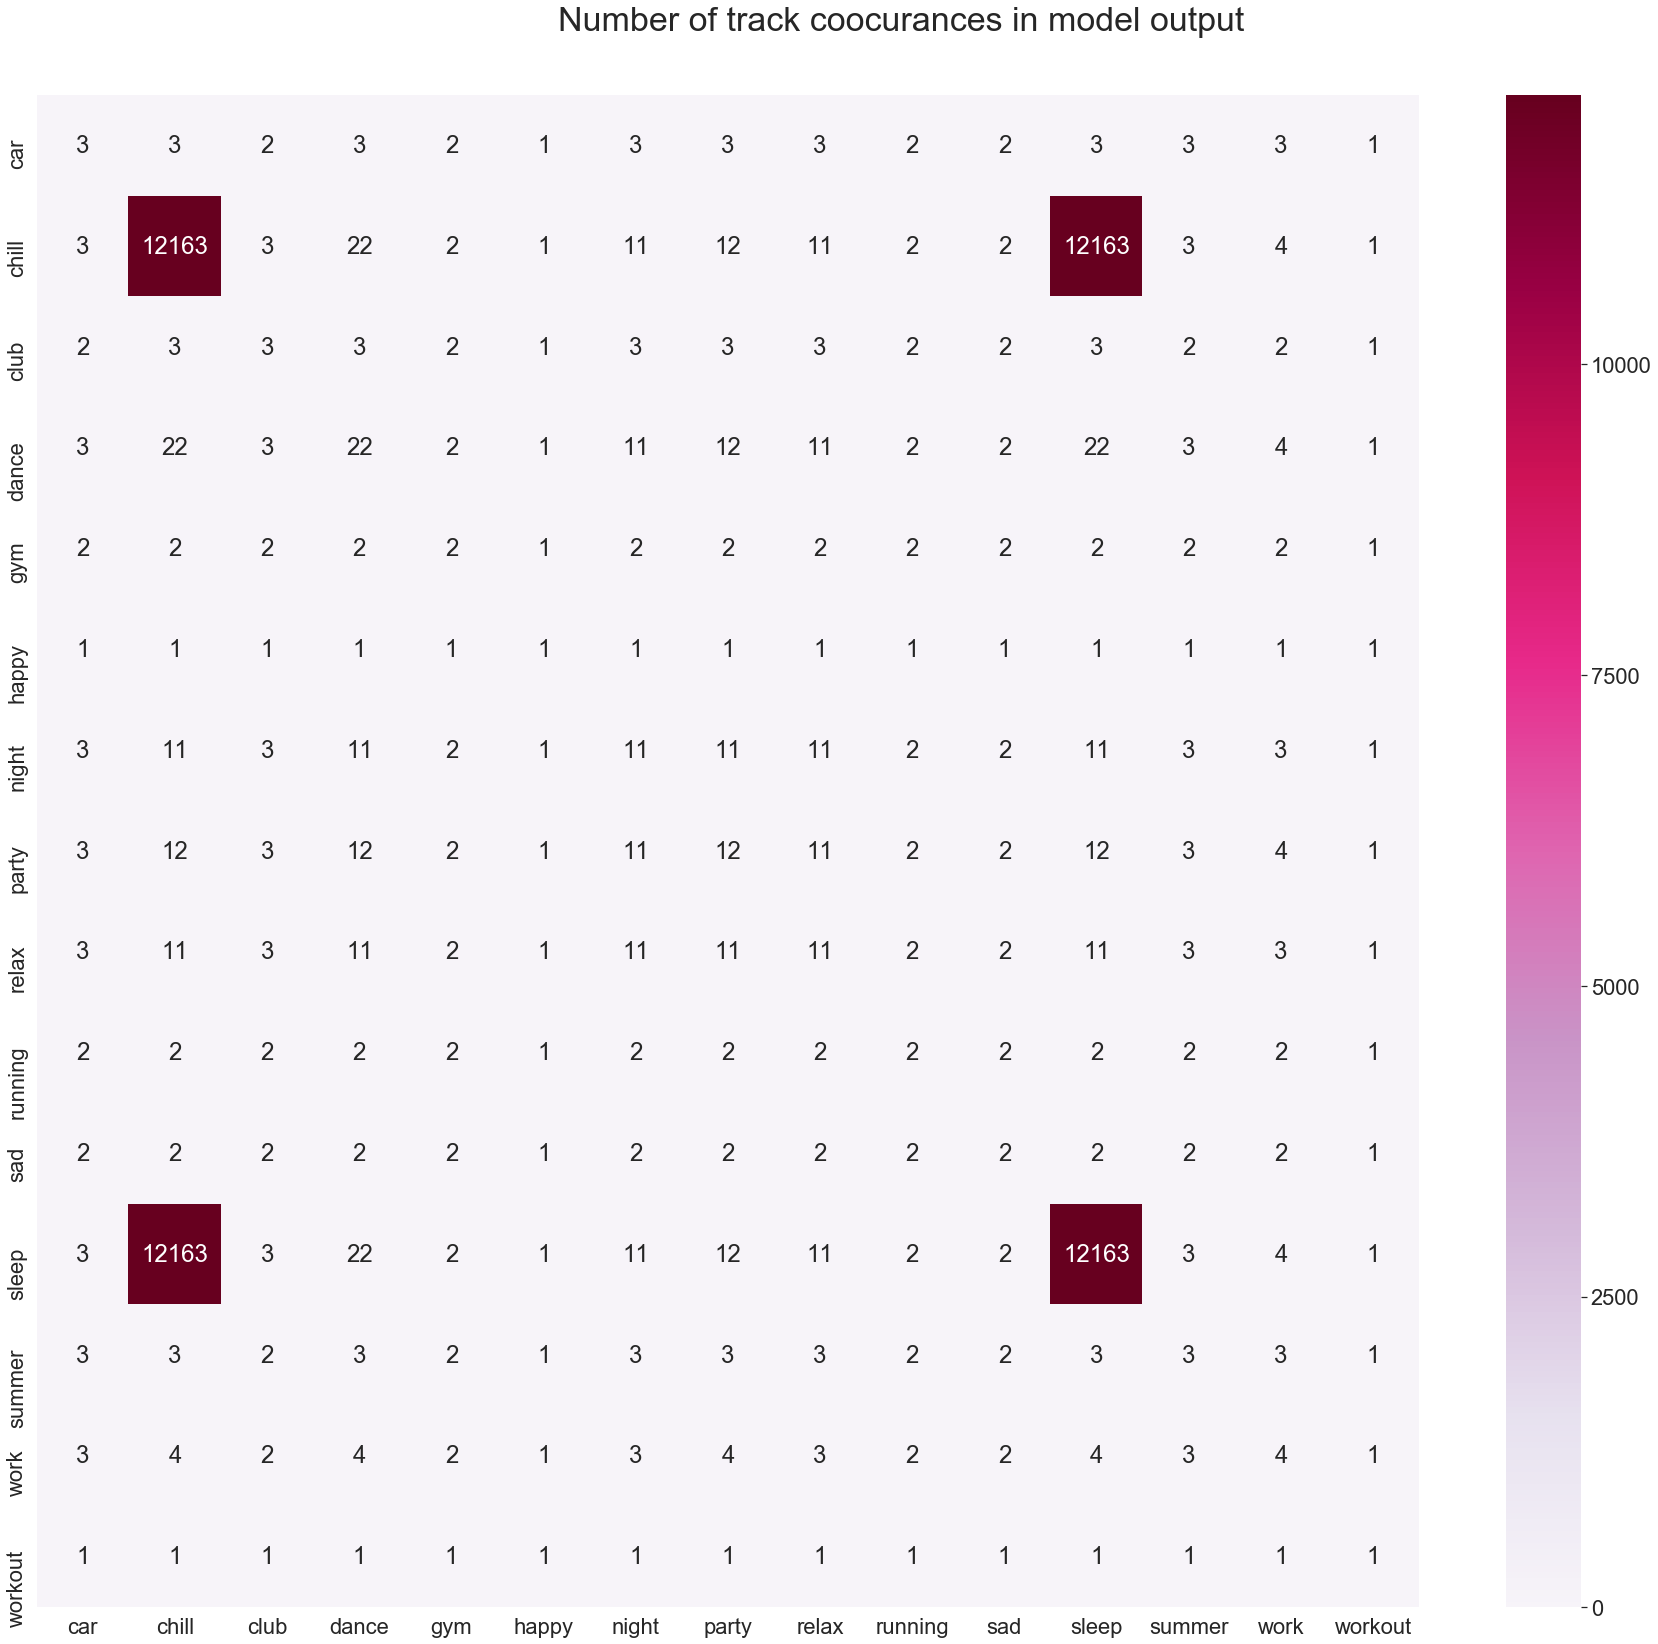

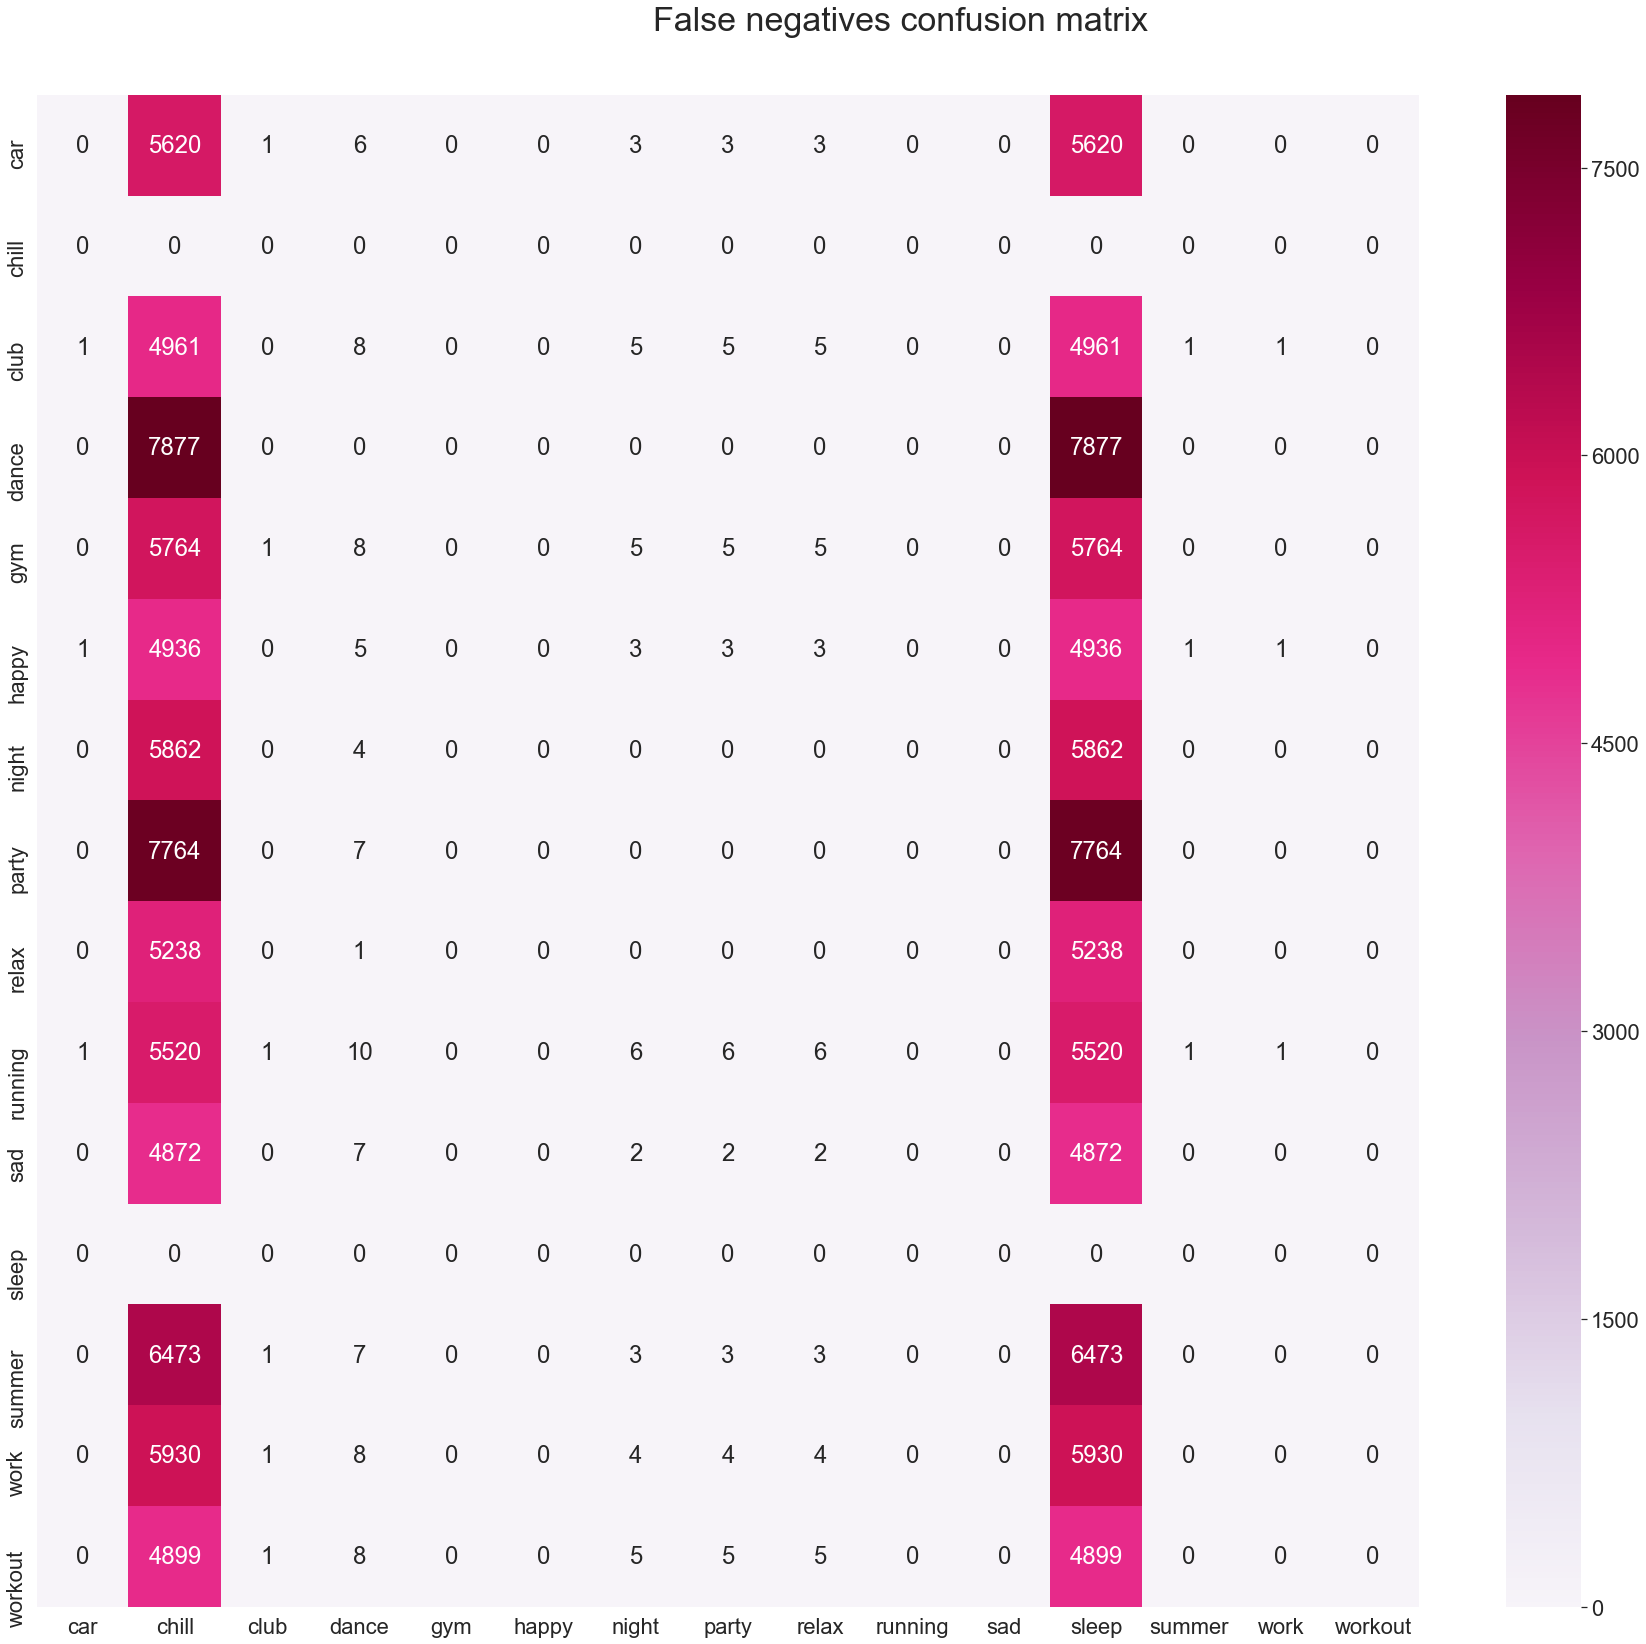

In [137]:
# General imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
LABELS_LIST = ['car', 'chill', 'club', 'dance', 'gym', 'happy', 'night', 'party', 'relax', 'running',
               'sad', 'sleep', 'summer', 'work', 'workout']

def plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth, LABELS_LIST):
    # Creating a plot of true positives vs all positives
    true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
    true_positives_df = pd.DataFrame(columns=LABELS_LIST)
    true_positives_df.index.astype(str, copy=False)
    true_positives_df.loc[0] = true_positives_perclass
    percentage_of_positives_perclass = sum(groundtruth)
    true_positives_df.loc[1] = percentage_of_positives_perclass
    true_positives_df.index = ['True Positives', 'Positive Samples']
    true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)
    # Plot the figure
    labels = [label + " (" + "{:.1f}".format(true_positives_ratio_perclass[idx] * 100) + "%) " for idx, label in
              enumerate(LABELS_LIST)]
    true_positives_df.columns = labels
    true_positives_df.T.plot.bar(figsize=(32, 22), fontsize=28)
    plt.xticks(rotation=45)
    plt.title(
        "Number of true positive per class compared to the total number of positive samples \n Average true positive rate: " + "{:.2f}".format(
            true_positives_ratio_perclass.mean()))

def plot_output_coocurances(model_output_rounded, LABELS_LIST):
    # Getting coocuarances
    test_pred_df = pd.DataFrame(model_output_rounded, columns=LABELS_LIST)
    coocurrances = pd.DataFrame(columns=test_pred_df.columns)
    for column in test_pred_df.columns:
        coocurrances[column] = test_pred_df[test_pred_df[column] == 1].sum()
    coocurrances = coocurrances.T
    # Plotting coocurances
    plt.figure(figsize=(30, 30));
    sn.set(font_scale=2)  # for label size
    cmap = 'PuRd'
    plt.axes([.1, .1, .8, .7])
    plt.figtext(.5, .83, 'Number of track coocurances in model output', fontsize=34, ha='center')
    sn.heatmap(coocurrances, annot=True, annot_kws={"size": 24}, fmt='.0f', cmap=cmap);


def plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth, LABELS_LIST):
    # Getting false negatives coocuarances
    test_pred_df = pd.DataFrame(model_output_rounded, columns=LABELS_LIST)
    test_classes_df = pd.DataFrame(groundtruth, columns=LABELS_LIST)
    FN_coocurrances = pd.DataFrame(columns=test_pred_df.columns)
    for column in test_pred_df.columns:
        FN_coocurrances[column] = test_pred_df[[negative_prediction and positive_sample
                                                for negative_prediction, positive_sample in
                                                zip(test_pred_df[column] == 0, test_classes_df[column] == 1)]].sum()
    FN_coocurrances = FN_coocurrances.T
    # Plotting coocurances
    plt.figure(figsize=(30, 30));
    sn.set(font_scale=2)  # for label size
    cmap = 'PuRd'
    plt.axes([.1, .1, .8, .7])
    plt.figtext(.5, .83, 'False negatives confusion matrix', fontsize=34, ha='center')
    sn.heatmap(FN_coocurrances, annot=True, annot_kws={"size": 24}, fmt='.0f', cmap=cmap);

# Round the probabilities at 0.5
model_output = test_pred_prob
model_output_rounded = np.round(model_output)
model_output_rounded = np.clip(model_output_rounded,0,1)
groundtruth = test_classes
# Create a dataframe where we keep all the evaluations, starting by prediction accuracy
accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
results_df = pd.DataFrame(columns=LABELS_LIST)
results_df.index.astype(str, copy=False)
percentage_of_positives_perclass = sum(groundtruth) / len(groundtruth)
results_df.loc[0] = percentage_of_positives_perclass
results_df.loc[1] = accuracies_perclass
results_df.index = ['Ratio of positive samples', 'Model accuracy']

# plot the accuracies per class
results_df.T.plot.bar(figsize=(22, 12), fontsize=18)
plt.title('Model accuracy vs the ratio of positive samples per class')
plt.xticks(rotation=45)
#plt.savefig(os.path.join(output_path, "accuracies_vs_positiveRate.pdf"), format="pdf")
#plt.savefig(os.path.join(output_path, "accuracies_vs_positiveRate.png"))

# Getting the true positive rate perclass
true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)
results_df.loc[2] = true_positives_ratio_perclass
# Get true negative ratio
true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                   * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
results_df.loc[3] = true_negative_ratio_perclass
# compute additional metrics (AUC,f1,recall,precision)
auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in range(len(LABELS_LIST))]
results_df = results_df.append(
    pd.DataFrame([auc_roc_per_label, precision_perlabel, recall_perlabel, f1_perlabel, kappa_perlabel], columns=LABELS_LIST))
results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                    'True negatives ratio', "AUC", "Recall", "Precision", "f1-score", "Kappa score"]

# Creating evaluation plots
plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth, LABELS_LIST)
plot_output_coocurances(model_output_rounded, LABELS_LIST)
plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth, LABELS_LIST)


results_df['average'] = results_df.mean(numeric_only=True, axis=1)
results_df.T.to_csv("/home/karim/Documents/research/exeriment_results_server_backup/experiments_results/embeddings_C4/2019-09-11_15-18-58/results_report.csv", float_format="%.2f")